# **TP3 - Grupo 4**
Pedro Paulo Costa Pereira - A88062

Tiago André Oliveira Leite - A91693

# **Problema - Sistema de Travgem ABS**
No contexto do sistema de travagem ABS (“Anti-Lock Breaking System”), pretende-se construir um autómato híbrido que descreva o sistema e que  possa ser usado para verificar as suas propriedades dinâmicas.

    
1. A componente discreta do autómato contém os modos:  `Start`,  `Free`,  `Stopping`, `Blocked`, e `Stopped`. No modo `Free`  não existe qualquer força de travagem; no modo `Stopping` aplica-se a força de travagem alta; no modo `Blocked` as rodas estão bloqueadas em relação ao corpo mas o veículo  desloca-se; no modo `Stopped` o veículo está imobilizado.


2. A componente contínua  do autómato usa variáveis contínuas $\,V,v\,$ para descrever a  `velocidade do corpo`  do veículo em relação ao solo e a `velocidade linear das rodas` também em relação ao solo. 
    Assume-se que o sistema de travagem exerce uma força de atrito  nos travões proporcional à diferença das duas velocidades.  A dinâmica contínua está descrita  abaixo no bloco Equaçoes de Fluxo.


3. Os “switchs” (“jumps”) são a componente de projeto deste trabalho; cabe ao aluno definir quais devem ser estas  condições de modo a que o sistema tenha um comportamento desejável: imobilize-se depressa e não “derrape” muito.


4. Faça
    1. Defina um autómato híbrido que descreva a dinâmica do sistema segundo as notas abaixo indicadas e com os “switchs” por si escolhidos.
    2. Modele em lógica temporal linear LT  propriedades que caracterizam o comportamento desejável do sistema. Nomeadamente 
        1. ”o veículo imobiliza-se completamente em menos de $t$ segundos” 
        2. “a velocidade $V$ diminui sempre com o tempo”.
    3. Codifique em SMT’s o modelo que definiu em a.
    4. Codifique a verificação das propriedades temporais que definiu em b.

<img src="e.png" style="width:700px;height:400px"/>

**Equações de Fluxo** 

1. Durante  a travagem não existe qualquer  força no sistema excepto as forças de atrito. Quando uma superfície se desloca em relação à outra, a força de atrito  é proporcional à força de compressão entre elas. 
2. No contacto rodas/solo o atrito é constante porque a força de compressão é o peso; tem-se $f = a\cdot P$ sendo  $a$ a constante de atrito e $P$ o peso. Ambos são fixos e independentes do modo.
3. No contacto corpo/rodas,  a força de compressão é a força de travagem que aqui se assume como proporcional à diferença de velocidades  $F =  c\cdot (V-v)$.  A  constante de proporcionalidade $c$ depende do modo: é elevada no modo `Stopping` e baixa nos outros.
4. Existe um atrito no contacto corpo/ar  que é aproximado por uma constante positiva $\,b$.
5. As equações que traduzem a dinâmica  do sistema são, em todos os modo excepto `Blocked`,

$$\begin{array}{c} \dot{V} & = & - c\cdot(V-v) - b\\ \dot{v} & = & -a\cdot P  + c\cdot(V-v) \end{array}$$   

e , no modo `Blocked`,  a dinâmica do sistema é  regida por

$$
\begin{array}{c} (V = v) \;\land\; (\,\dot{V}\,=\, -a\cdot P - b\,) \end{array} $$


6. Tanto no modo `Blocked`  como no modo `Free`  existe um “timer” que impede que se permaneça nesses modo mais do que $\,\tau\,$segundos. Os $\mathsf{jumps}(V,v,t,V',v',t')\,$ com origem nesses modos devem forçar esta condição.
7. No instante inicial assume-se $\,V = v\,=\,V_0$  ,  em que a velocidade $V_0$ é o “input” do problema.

## Variaveis do sistema

**Variaveis continuas:**<br>
> $T$ ⟶ tempo<br>
> $V$ ⟶ velocidade do veiculo<br>
> $R$ ⟶ velocidade das rodas (v)<br>
> $Timer$ ⟶ Timer utilizado nos modos Free e Blocked (TIMER)

**Variaveis Discretas:**<br>
> $M$ ⟶ Modo



In [1]:
from z3 import *
import pygraphviz as pgv
from IPython.display import Image

In [2]:
def draw(dot):
    return Image(pgv.AGraph(dot).draw(format='png', prog='dot'))

## A. Autómato híbrido que descreve a dinâmica do sistema

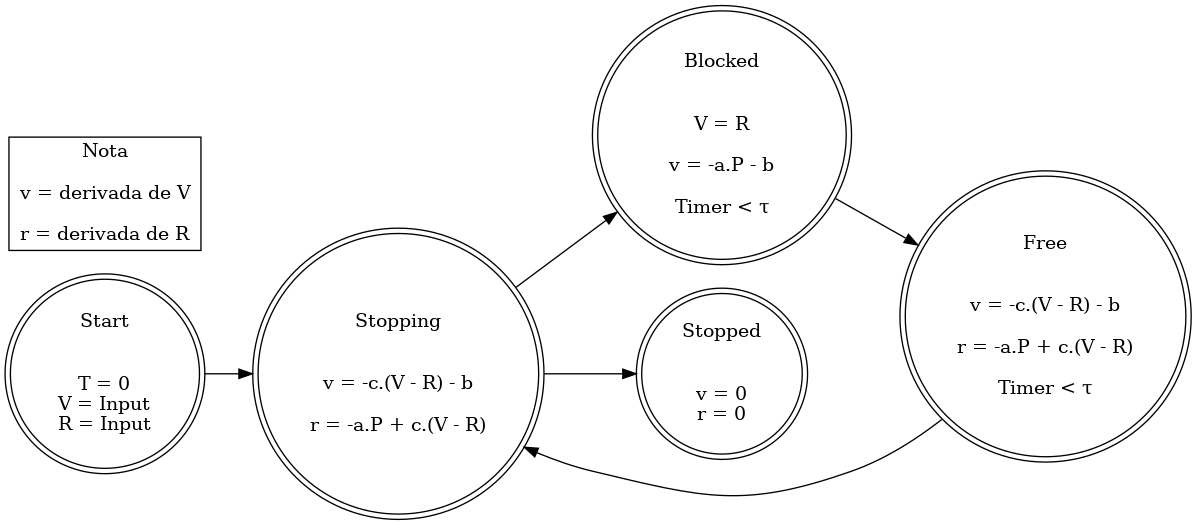

In [51]:
ABS = """digraph{
    rankdir=LR;
    Start [shape=doublecircle, label="Start\n\n\nT = 0\nV = Input\nR = Input"];
    Free [shape = doublecircle, label="Free\n\n\nv = -c.(V - R) - b\n\nr = -a.P + c.(V - R)\n\nTimer < τ"];
    Stopping [shape = doublecircle, label="Stopping\n\n\nv = -c.(V - R) - b\n\nr = -a.P + c.(V - R)"];
    Blocked [shape = doublecircle, label="Blocked\n\n\nV = R\n\nv = -a.P - b\n\nTimer < τ"];
    Stopped [shape = doublecircle, label="Stopped\n\n\nv = 0\nr = 0"];
    
    Nota [shape=box, label="Nota\n\nv = derivada de V\n\nr = derivada de R"];
  
    Start -> Stopping;
    Free -> Stopping;
    Stopping -> Blocked;
    Stopping -> Stopped;
    Blocked -> Free;

    
}"""

draw(ABS)

## B. Modelação em LT das propriedades que garantem comportameneto desejável
### a. ”o veículo imobiliza-se completamente em menos de $t$ segundos”.<br>
> $T < t \quad \land\ \quad M = Stopped$

### b. “a velocidade $V$ diminui sempre com o tempo”.
> $ t' > t \quad \implies\ \quad V' < V$


## Codificação do Modelo

In [8]:
Mode, (START,FREE, STOPPING, BLOCKED, STOPPED) = EnumSort('Mode', ('START','FREE','STOPPING', 'BLOCKED','STOPPED'))

In [57]:
a = 1
b = 1 
c = {}
c['STOPPING'] = 2
c['FREE'] = 1
P = 1000
v_inicial = 40

In [19]:
def declare(i):
    s = {}
    s['T'] = Real('T'+str(i)) # tempo
    s['V'] = Real('V'+str(i)) # velociadae veiculo
    s['R'] = Real('R'+str(i)) # velocidade rodas
    s['M'] = Const('M'+str(i),Mode) # modo
    s['TIMER'] = Real('TIMER'+str(i))
    return s

In [12]:
def init(s):
    return And(s['T'] == 0, s['V'] == v_inicial, s['R'] == v_inicial, s['M'] == START) 

In [20]:
def trans(s,p):
    
    start2stopping = And(s,['M']==START, p['M']==STOPPING ,s['T']==p['T'], s['V']==p['V'], s['R']==p['R'])
    
    
    stopping2blocked = And(s,['M']==STOPPING, p['M']==BLOCKED ,s['T']==p['T'], 
                           s['V']==p['V'], s['R']==p['R'],p['TIMER']==0)
    
    stopping2stopped = And(s,['M']==STOPPING, p['M']==STOPPED ,s['T']==p['T'], s['V']==p['V'], s['R']==p['R'])
    
    stopping2stopping = And() # completar
    
    free2stopping  =  And(s,['M']==FREE, p['M']==STOPPING ,s['T']==p['T'], s['V']==p['V'], s['R']==p['R'])
    
    free2free = And() # completar
    
    blocked2free = And(s,['M']==BLOCKED, p['M']==FREE ,s['T']==p['T'],
                       s['V']==p['V'], s['R']==p['R'], p['TIMER']==0)
    
    blocked2blocked = And() # completar
    
    stopped2stopped = And(s['M']==STOPPED, p['M']==STOPPED, s['T']==0, p['T']==0, 
                          s['V']==0, p['V']==0, s['R']==0, p['R']==0)
    
    
    
    return Or(start2stopping, 
              stopping2blocked, stopping2stopped, stopping2stopping, 
              free2stopping, free2free, 
              blocked2free, blocked2blocked, 
              stopped2stopped)

In [53]:
def gera_traco(declare,init,trans, k):
    s = Solver()
    traco = {}
    for i in range(k):
        traco[i] = decalre(i)
    s.add(init(traco[0]))
    for i in range(k-1):
        s.add(trans(traco[i],traco[i+1]))
    status = s.check()
    if status == sat:
        m = s.model()
        for i in range(k):
            print(i)
            for v in traco[i]:
                if traco[i][v].sort == RealSort():
                    print(v,'=', float(m[traco[i][v]].numerator_as_long())/float(m[traco[i][v]].denominator_as_long()))
                else:
                    print(v,"=",m[traco[i][v]])
    elif status == unsat:
        print("Não ha execuções possiveis")
    else:
        print("Resultado impossivel de obter!")

## Verificação das propriedades

In [14]:
def propA(state):
    return Implies(state['M']==STOPPED, state['T']<t)

def propB(pre,pos):
    return Implies(pre['T']<pos['T'],pre['V']>pos['V'])

In [52]:
def bmc_always(declare,init,trans,inv,k):
    for i in range(1, k+1):
        s = Solver()
        traco = {}
        for i in range(k):
            traco[i] = declare(i)
        s.add(init(traco[0]))
        for i in range(k-1):
            s.add(trans(traco[i],traco[i+1]))
            s.add(Not(propB(traco[i],traco[i+1])))
        s.add(Not(inv(traco[k-1])))
        status = s.check()
        if status == sat:
            m = s.model()
            for i in range(k):
                print(i)
                for v in traco[i]:
                    if traco[i][v].sort() == RealSort():
                        print(v,'=', float(m[traco[i][v]].numerator_as_long())/float(m[traco[i][v]].denominator_as_long()))
                    else:
                        print(v,"=",m[traco[i][v]])
            return
    print("A propriedade pode ser verdade...")